<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/Actor_Critic_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

어떤 상태에서 특정한 액션을 취하면 리워드가 발생한다.
정책신경망에서 어떤 상태일때 액선이 산출되고 그 산출로 인한 리워드가 최대가 되도록 정책신경망의 가중치를 조정한다. 그러면 리워드가 최대가 되는 액션을 산출하는 정책신경망이 될 것이다. 

loss함수는 리워드가 최대가 되는 액션을 산출했을 때, 마이너스 무한대가 되도록 조정하면 된다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

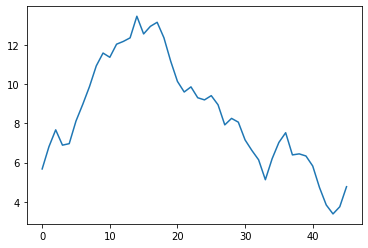

In [2]:
# 환경 모듈

def env():
  start_price = 3
  pricej=[]
  for i in range(50):
    change = np.random.rand(1)*1.2
    direction = np.random.choice(2, p=[0.5, 0.5])
    if direction == 1:
      if start_price - change[0] <= 0:
         p = 1.0
      else:
         p = start_price - change[0]     
    else: 
      p = start_price + change[0] 
    start_price = p
    pricej.append(p)
#  p_mean = np.mean(price)
#  p_std = np.std(price)
#  price = (price - p_mean)/p_std
  
  p_serise= []
  for i in range(46):
    serise = [pricej[i],pricej[i+1], pricej[i+2], pricej[i+3], pricej[i+4]]
    serise = np.array(serise)
    p_serise.append(serise)
  p_serise= p_serise[0:50]
  p_serise = np.array(p_serise)
  p_serise_lstm = p_serise.reshape(46, 5, 1)  # p_serise의 길이는 46이다. LSTM을 사용할 때 데이터 input 형태
  price_lstm = pricej[4:]
  price_lstm = np.array(price_lstm)
  return p_serise, p_serise_lstm, price_lstm 

p_serise, p_serise_lstm, price_lstm = env()
plt.plot(price_lstm)
plt.show()

In [ ]:
price_data = [p_serise_lstm[j] for j in range(5)] 
price_data = np.array(price_data)
price_data.shape

(5, 5, 1)

In [ ]:
p_serise_lstm[0]

array([[3.70549417],
       [2.80407724],
       [2.45759833],
       [2.27523064],
       [3.10865426]])

이것은 Test이다. LSTM을 적용한 모델로 price 변동을 학습하는지 체크한다.
예측을 하는 것은 아니지만 주어진 데이터를 완벽하게 학습하고 재현한다.

In [3]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)


import tensorflow as tf

import numpy as np

from tensorflow import keras
import keras.layers as layers
from keras.layers import Dense, LSTM,Input
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K 



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [4]:
def policy_model_lstm (lr):
  inp_L = layers.Input(shape=(5,1))  # 타입스텝수 5개, 특성개수 1개
  dense_L = LSTM(5)(inp_L)
  dense_L = Dense(64)(dense_L) 
  output_s = layers.Dense(1)(dense_L)

  model_train = Model(inputs=inp_L, outputs = output_s)
  model_train.compile(loss='mse', optimizer=Adam(lr), metrics = ['mae'])
  return model_train 

In [5]:
model_train_test = policy_model_lstm(0.01)

In [6]:
model_train_test.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 589
Trainable params: 589
Non-trainable params: 0
_________________________________________________________________


In [7]:
history_test = model_train_test.fit(p_serise_lstm, price_lstm, epochs=100, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [9]:
p_f = model_train_test.predict(p_serise_lstm)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


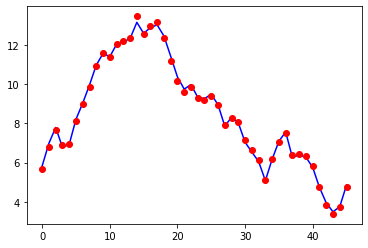

In [10]:
plt.plot(p_f,"b")
plt.plot(price_lstm, 'ro')
plt.show()

여기부터 정책신경망 이다.

In [92]:
class Agent(object):
  def __init__(self, alpha, beta, gamma= 0.99, n_actions=2, layer1_size=10, layer2_size=64, layer3_size=64, input_dims=5, fname='reinforce.h5'):
    self.gamma = gamma
    self.alpha = alpha
    self.beta = beta
    self.input_dims = input_dims
    self.fc1_dims = layer1_size
    self.fc2_dims = layer2_size
    self.fc3_dims = layer3_size
    self.n_actions = n_actions
    self.balance = [20, 0, 0]

    self.actor, self.critic, self.policy = self.build_actor_critic_network()
    self.action_space = [i for i in range(n_actions)]
    self.model_file = fname
     
  def build_actor_critic_network(self):
   # actor와 critic이 신경망 몸체를 공유하는 구조임

    input=Input(shape=(5,1))
    delta = Input(shape=[1])
    dense1 = LSTM(self.fc1_dims)(input)
    dense2 = Dense(self.fc2_dims)(dense1)
    dense3 = Dense(self.fc3_dims)(dense2)
    probs = Dense(self.n_actions, activation='softmax')(dense3)
    values = Dense(1, activation='linear')(dense3)

    def custom_loss(y_true, y_pred):
      out = K.clip(y_pred, 1e-8, 1-1e-8)
      log_lik = K.sum(y_true*K.log(out), axis=1)*delta
      return - log_lik
   
    actor = Model(inputs=[input, delta], outputs = [probs]) # [] 필요여부 체크
    actor.compile(optimizer = Adam(lr=self.alpha), loss=custom_loss)
    
    critic = Model(inputs = [input], outputs = [values])
    critic.compile(optimizer = Adam(lr=self.beta), loss='mse')
   
    policy = Model(inputs = [input], outputs = [probs]) # compile이 필요없다

    return actor, critic, policy

  def choose_action(self, observation):
    state = observation[np.newaxis, :] # [1.0, 1.0]을 [[1.0, 1.0]]와 같이 한축을 추가한다.
    probabilities = self.policy.predict(state)[0]
    action = np.random.choice(self.action_space, p=probabilities)
    return action

  def validate_action(self, action, observation):
    price = observation[4]
    if action == 0:  # 0은 매수, 1은 보류, 2는 매도
      if self.balance[0] - price < 0:
        action_validated = 1
      else:
        action_validated = 0        
    if action == 1:
      if self.balance[2] > 0 :
        action_validated = 2
      else:
        action_validated = 1
    before_act_balance = [self.balance[0], self.balance[1], self.balance[2]] 

    return action_validated, before_act_balance  

  def balance_update(self, observation, action_validated):
    price = observation[4]
    if action_validated == 0:
      self.balance[0] = self.balance[0] - price
      self.balance[1] = price
      self.balance[2] = self.balance[2] + 1
    if action_validated == 1:
      self.balance[1] = price
    if action_validated == 2:
      self.balance[0] = self.balance[0] + price
      self.balance[1] = price
      self.balance[2] = self.balance[2] -1
    balance_updated = [self.balance[0], self.balance[1], self.balance[2]]
    present_value = self.balance[0] + self.balance[1] * self.balance[2]
    return balance_updated, present_value

  def pv_ratio(self, before_act_balance, balance_updated):
    pv_ratio = (balance_updated[0] + balance_updated[1] * balance_updated[2])/(before_act_balance[0] + before_act_balance[1] * before_act_balance[2])
    if pv_ratio > 1.0:
      reward = 1
    else:
      reward = 0
    return pv_ratio, reward

  def hold_ratio(self, balance_updated, observation, present_value):  # 주식보유 비율
    price = observation[4] 
    hold_ratio = balance_updated[2] / (present_value / price)
    return hold_ratio


  def learn(self, state, action, reward, state_, done): 

    # action은 choose_action 함수로부터, state는 환경으로 부터, state_은 새롭게 받은 다음 step의 환경
    # reward는 state_와 같이 환경으로부터 받는 다음 step의 reward 
    # done은 환경으로부터 받는 episode의 종료여부

    state = state[np.newaxis, :]
    state_ = state_[np.newaxis, :]  

    critic_value_ = self.critic.predict(state_)
    critic_value = self.critic.predict(state)

    
    # t시점의 신경망으로 현재 state의 value와 t+1 시점의 value를 계산 

    target = reward + self.gamma*critic_value_*(1-int(done))  # int(False) == 0
    delta = target - critic_value

        
    actions = np.zeros([1, self.n_actions])
    actions[np.arange(1), action] = 1.0 # action memory 길이만큼 zero 리스트를 만들고, 각 리스트에 선택한 행동에 1을 넣어준다

    self.actor.fit([state, delta], actions, verbose=0)
    self.critic.fit(state, target, verbose=0)
     


  def reset_balance(self):
    self.balance = [20,0,0]



In [88]:
agent = Agent(alpha = 0.0001, beta = 0.0001)
balance = [20,0,0]

In [89]:
observation = p_serise_lstm[0]
observation_ = p_serise_lstm[1]

action = agent.choose_action(observation)
action_validated, before_act_balance = agent.validate_action(action, observation)
balance_updated, present_value=agent.balance_update(observation, action_validated)
pv_ratio, reward = agent.pv_ratio(before_act_balance, balance_updated)
hold_ratio = agent.hold_ratio(balance_updated, observation, present_value)
agent.learn(observation, action, reward, observation_, False)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


critic_value: [[0.08921144]]
target: [[0.10420059]]
delta: [[0.01498915]]


여기부터는 학습의 영역이다.

In [93]:
# random action과 신경망의 선택 action을 조정해야 한다.


num_episode = 0.0
num_episodes = 100.0

agent = Agent(alpha = 0.0001, beta = 0.0001)

while num_episode < num_episodes:

  action_history = []
  wealth_history = []
  agent.reset_balance()

  for i in range(len(p_serise_lstm)):

    if i < (len(p_serise_lstm)-1):
      done = False    
      observation = p_serise_lstm[i]
      observation_ = p_serise_lstm[i+1]
      action = agent.choose_action(observation)
      action_validated, before_act_balance = agent.validate_action(action, observation)
      balance_updated, present_value=agent.balance_update(observation, action_validated)
      pv_ratio, reward = agent.pv_ratio(before_act_balance, balance_updated)
      hold_ratio = agent.hold_ratio(balance_updated, observation, present_value)
   
      action_history.append(action)
      wealth_history.append(present_value)

      if (reward == 1): 
        agent.learn(observation, action, reward, observation_, done)
      continue

  
  if (num_episode+1) % 20 == 0:
    print(wealth_history[-1])

  num_episode += 1.0
   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[18.33840844]
[14.32583415]
[19.02043023]
[24.29586253]
[16.02000252]


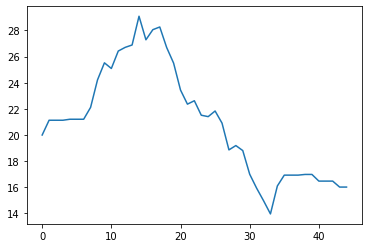

In [94]:
plt.plot(wealth_history)
plt.show()

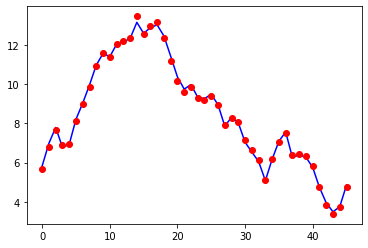

In [95]:
plt.plot(p_f,"b")
plt.plot(price_lstm, 'ro')
plt.show()

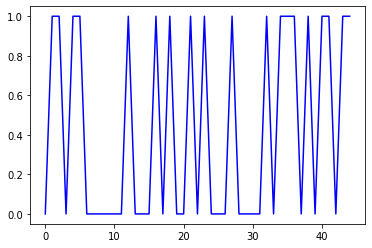

In [96]:
plt.plot(action_history, 'b')
plt.show()

In [ ]:
# 학습을 위한 배치 데이터를 만든다.

def get_batch(transaction_history):


  for i in range(len(transaction_history)):

    if transaction_history[i][9] == 1:

      y = np.full((len(transaction_history), 2), 0.0) 
      for j in range(i+1):
        k = transaction_history[j][2] # k는 당초 신경망이 추천한 값으로 0구매, 1는 매도 이다. 
        y[j,k] = 1.0 # 신경망이 추천해 준 값을 1로 놓아, 0.0보다 높게 만든다. 이것은 각 행동에 대한 reword이자 action에 대한 추천확율이다.
      
      price_data = [p_serise_lstm[j] for j in range(i+1)]
      pv_ratios = [transaction_history[j][6] for j in range(i+1)]
      hold_ratios = [transaction_history[j][7] for j in range(i+1)]
      
      train_input =[]
      for pd, pr, hr in zip(price_data, pv_ratios, hold_ratios):
        pd = np.append(pd, pr)
        pd = np.append(pd, hr)
        train_input.append(pd)
      train_input = np.array(train_input)
      train_input = train_input.reshape(-1,7,1)

    elif transaction_history[i][9] == -1:
      
      y = np.full((len(transaction_history), 2), 1.0) 
      
      for j in range(i+1):
        k = transaction_history[j][2] # k는 당초 신경망이 추천한 값으로 0구매, 1는 매도 이다. 
        y[j,k] = 0.0 # 신경망이 추천해 준 값을 0로 놓아, 0.5보다 낮게 만든다. 반대 행동에 1.0의 보상을 주는 것과 같다.
      
      price_data = [p_serise_lstm[j] for j in range(i+1)]
      pv_ratios = [transaction_history[j][6] for j in range(i+1)]
      hold_ratios = [transaction_history[j][7] for j in range(i+1)]
      
      train_input =[]
      for pd, pr, hr in zip(price_data, pv_ratios, hold_ratios):
        pd = np.append(pd, pr)
        pd = np.append(pd, hr)
        train_input.append(pd)
      train_input = np.array(train_input)
      train_input = train_input.reshape(-1,7,1)

  return y, train_input






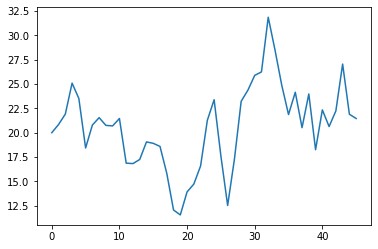

In [ ]:
plt.plot(wealth)
plt.show()

In [ ]:
# 거래와 관련된 모든 것을 기록한다.

def record(i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv):

  transaction_history.append([i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv])
  return transaction_history

In [ ]:
actions = []
for i in range(len(fkn)):
  actions.append(fkn[i][2])

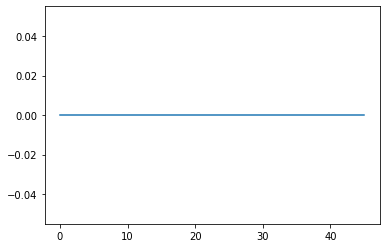

In [ ]:
plt.plot(actions)
plt.show()